In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better visuals
sns.set(style="whitegrid")

# Load the CSV file
df = pd.read_csv("/content/heart.csv")

# Display the first few rows
print("Head of the dataset:")
print(df.head())


Head of the dataset:
   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   52    1                0           125          212                    0   
1   53    1                0           140          203                    1   
2   70    1                0           145          174                    0   
3   61    1                0           148          203                    0   
4   62    0                0           138          294                    1   

   resting ecg  max heart rate  exercise angina  oldpeak  slope  \
0            1             168                0      1.0      2   
1            0             155                1      3.1      0   
2            1             125                1      2.6      0   
3            1             161                0      0.0      2   
4            1             106                0      1.9      1   

   major vessels flourosopy  thal  target  
0                         2     3       0  
1      

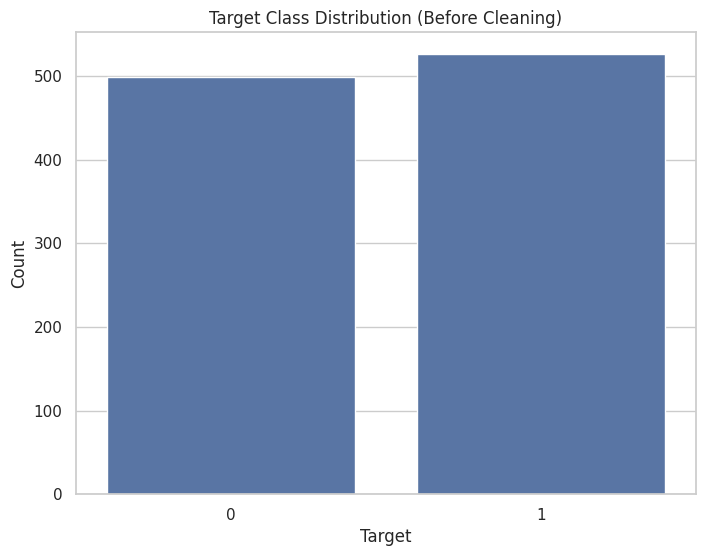

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x="target", data=df)
plt.title("Target Class Distribution (Before Cleaning)")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

In [ ]:
# Define the columns that cannot be 0 or have null values
cols_to_check = ["resting bp s", "cholesterol", "max heart rate"]

# Drop rows with NaN values in these columns
df_clean = df.dropna(subset=cols_to_check)

# Drop rows where any of these columns are 0
for col in cols_to_check:
    df_clean = df_clean[df_clean[col] != 0]

# Reset index for the cleaned dataframe
df_clean.reset_index(drop=True, inplace=True)

print("Rows before cleaning:", df.shape[0])
print("Rows after cleaning:", df_clean.shape[0])


Rows before cleaning: 1025
Rows after cleaning: 1025


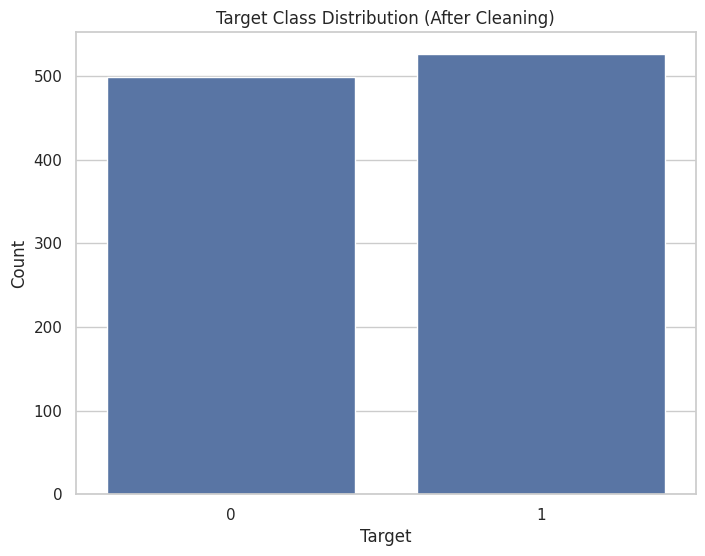

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x="target", data=df_clean)
plt.title("Target Class Distribution (After Cleaning)")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

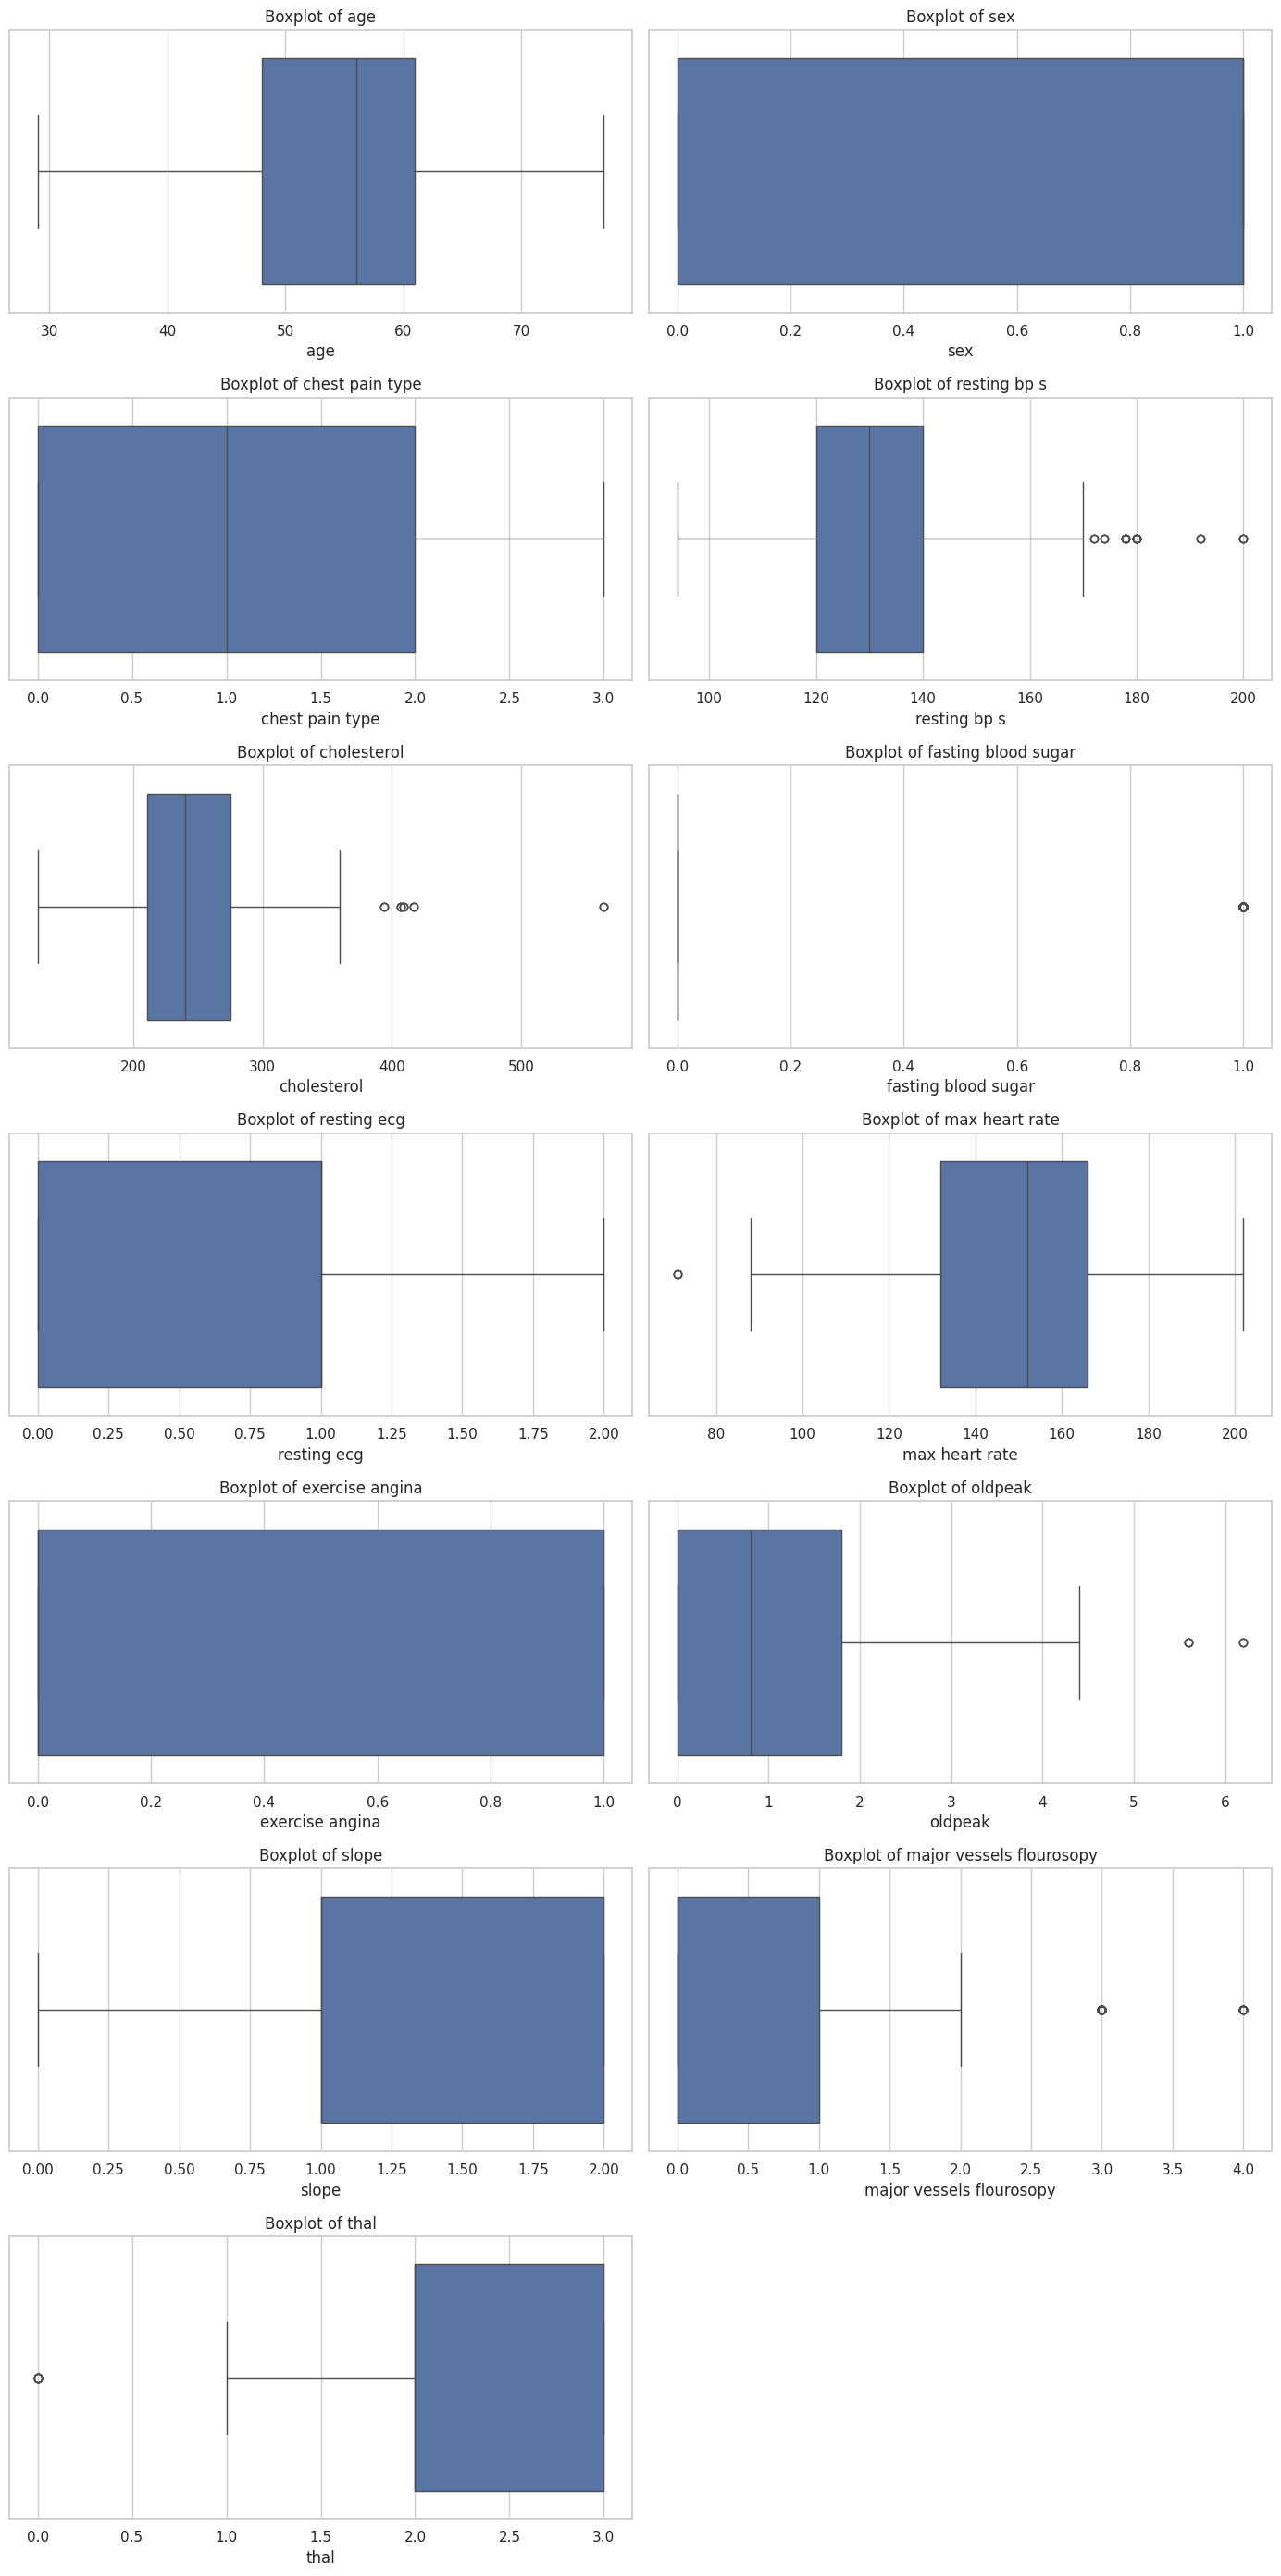

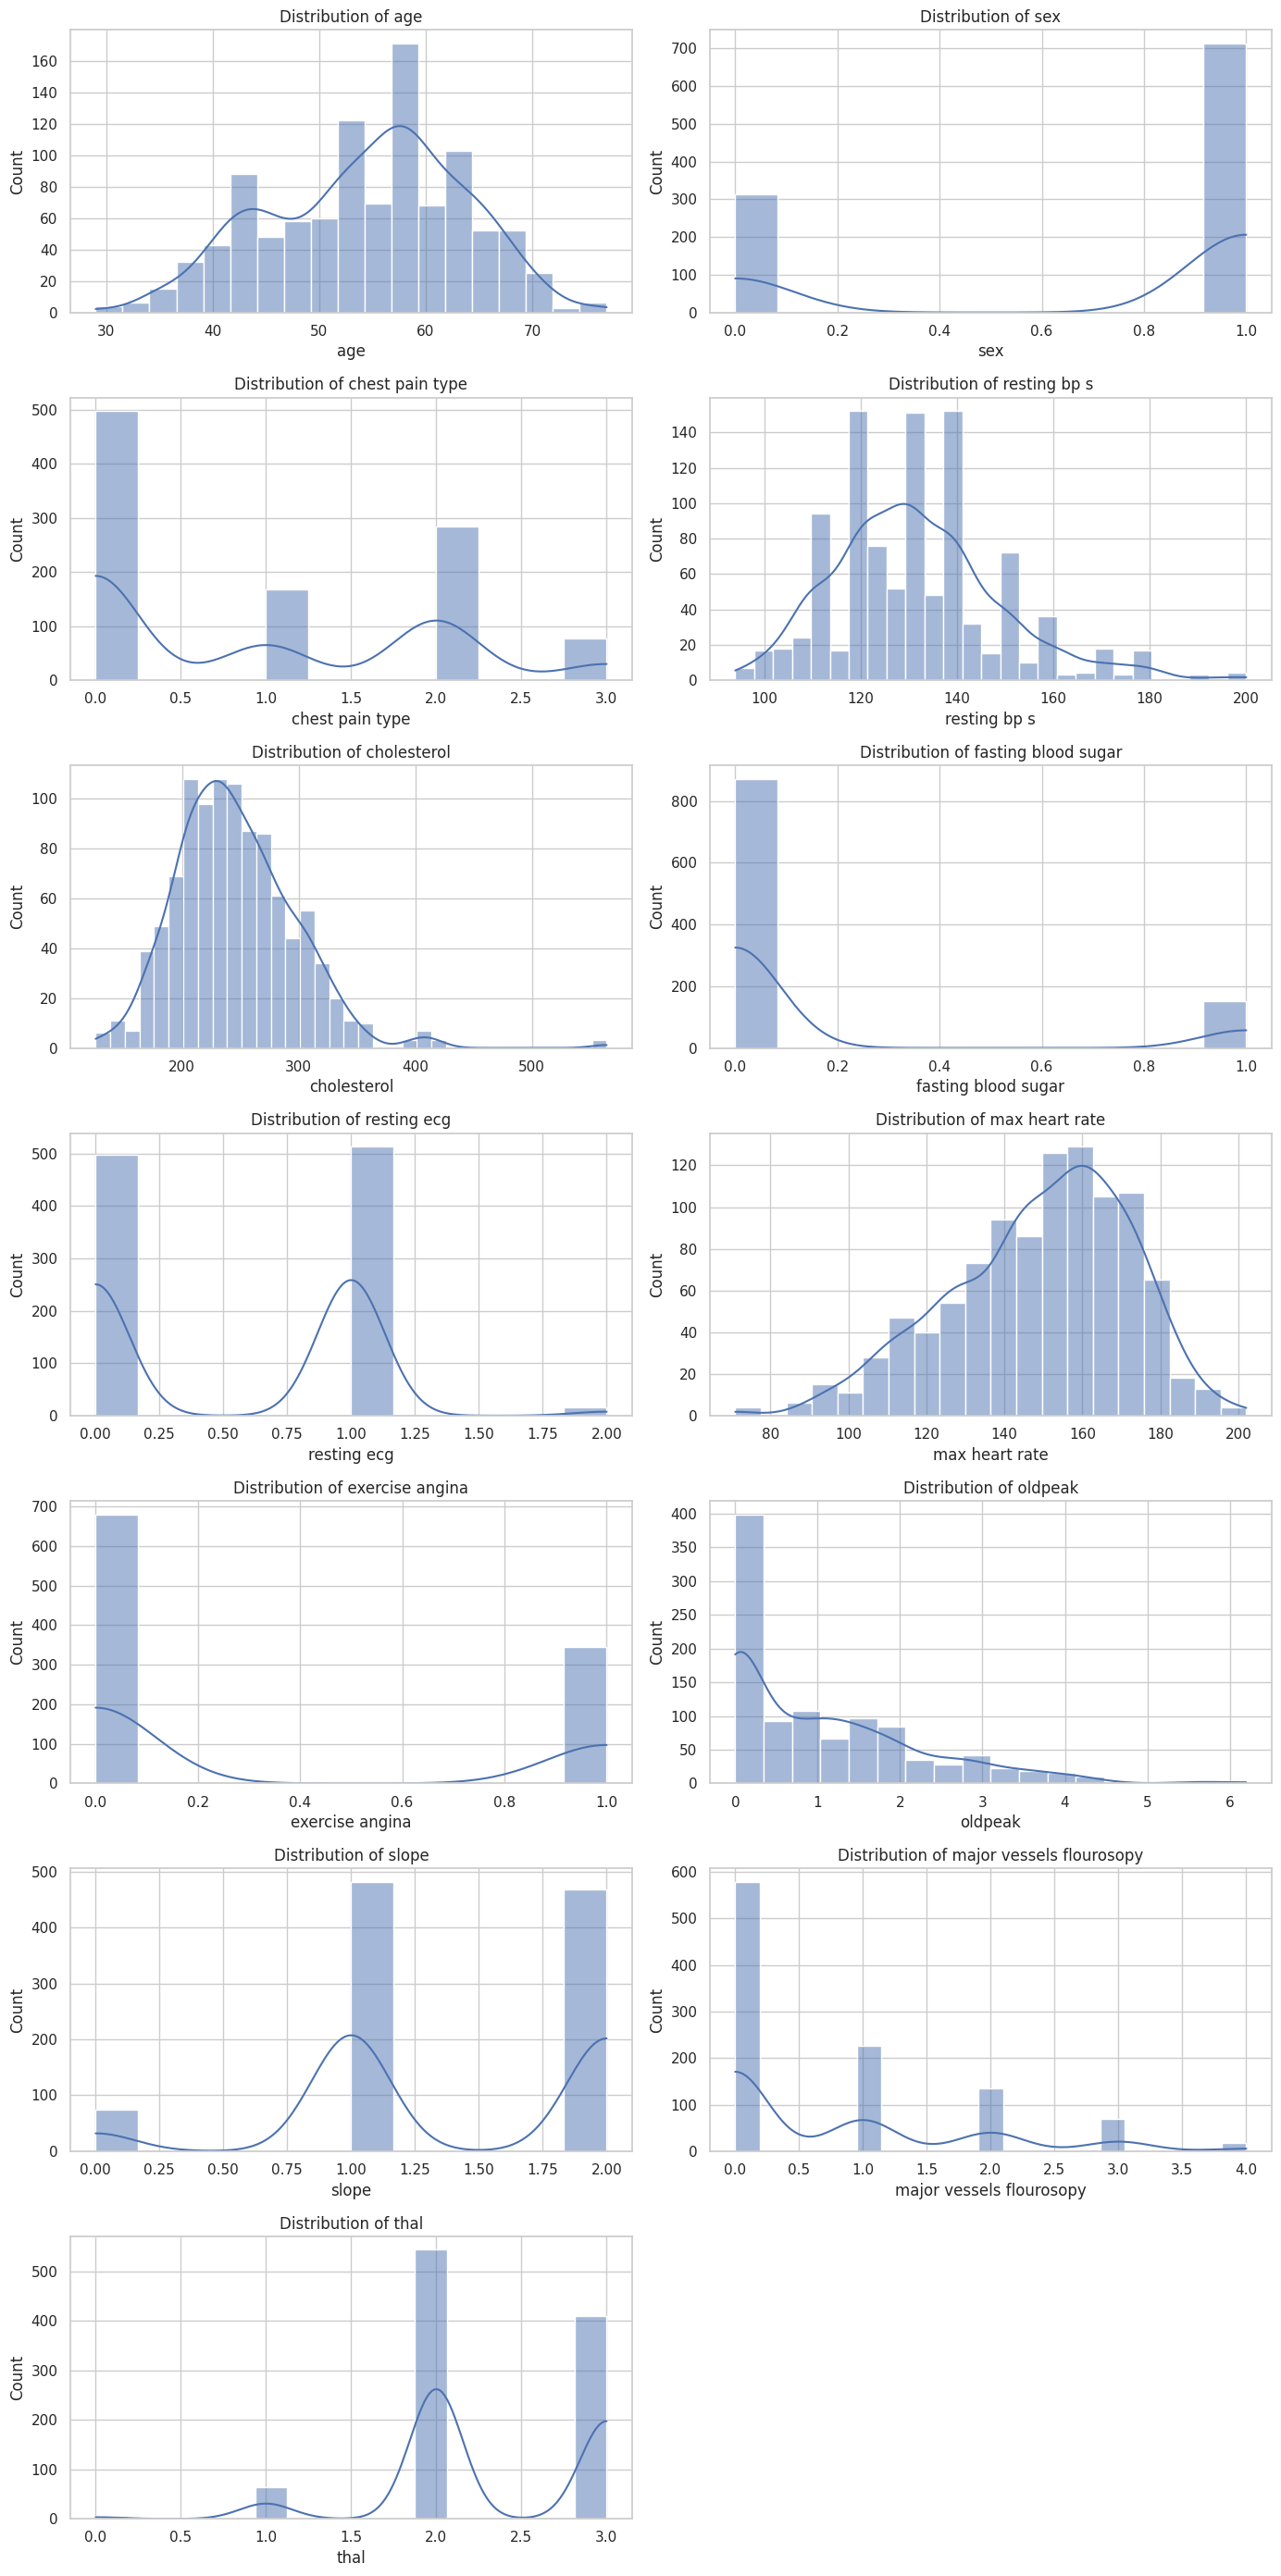

In [ ]:
import math

# List of features (excluding the target variable)
features = [col for col in df_clean.columns if col != "target"]

# Determine layout for the subplots
n_cols = 2
n_rows = math.ceil(len(features) / n_cols)

# Plot boxplots for outlier detection
plt.figure(figsize=(14, n_rows * 4))
for i, col in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# Plot histograms to check the distribution
plt.figure(figsize=(14, n_rows * 4))
for i, col in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_clean[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


In [ ]:
# Save the cleaned DataFrame to a CSV file without the index
df_clean.to_csv("clean_final.csv", index=False)
print("Cleaned data saved as 'clean_final.csv'.")


Cleaned data saved as 'clean_final.csv'.


#Model CatBoost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
RANDOM_STATE = 42

# Load the CSV file (replace 'clean_final.csv' with your file name if different)
df = pd.read_csv("/content/clean_final.csv")

# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

# First split: train+validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Second split: train (60% overall) and validation (20% overall) from train_val (i.e. 75:25 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_val
)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (610, 11) (610,)
Validation set: (204, 11) (204,)
Test set: (204, 11) (204,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the CatBoost model (silent mode to reduce verbosity)
cat_model = CatBoostClassifier(random_state=RANDOM_STATE, silent=True)

# Define hyperparameter distributions to search over
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'iterations': [100, 200, 500],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_distributions,
    n_iter=10,               # Number of parameter settings sampled
    scoring='accuracy',      # You can change this metric as needed
    cv=3,
    random_state=RANDOM_STATE,
    verbose=1
)

# Fit on the training set
random_search.fit(X_train, y_train)

# Display the best parameters found
print("Best hyperparameters:", random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 4}


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the validation set using the best estimator
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(X_val)

# Evaluate performance
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)
print("\nClassification Report on Validation Data:\n", classification_report(y_val, y_val_pred))


Validation Accuracy: 0.8823529411764706

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89       109
           1       0.91      0.83      0.87        95

    accuracy                           0.88       204
   macro avg       0.89      0.88      0.88       204
weighted avg       0.88      0.88      0.88       204



In [ ]:
# Combine train and validation sets
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# Initialize a new CatBoost model with the best hyperparameters
final_model = CatBoostClassifier(
    **random_search.best_params_,
    random_state=RANDOM_STATE,
    silent=True
)

# Train the final model on the full training data (train+validation)
final_model.fit(X_train_full, y_train_full)

# Evaluate on the test set
y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(y_test, y_test_pred))


Test Accuracy: 0.9117647058823529

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       108
           1       0.92      0.89      0.90        96

    accuracy                           0.91       204
   macro avg       0.91      0.91      0.91       204
weighted avg       0.91      0.91      0.91       204



#Revert original category

In [ ]:
import pandas as pd

# Load the cleaned CSV file
df = pd.read_csv("/content/clean_final.csv")

# Map 'sex' (assuming 0: Female, 1: Male)
sex_mapping = {
    0: "Female",
    1: "Male"
}
df["sex"] = df["sex"].map(sex_mapping)

# Map 'chest pain type'
chest_pain_mapping = {
    1: "Typical Angina",
    2: "Atypical Angina",
    3: "Non-Anginal Pain",
    4: "Asymptomatic"
}
df["chest pain type"] = df["chest pain type"].map(chest_pain_mapping)

# Map 'fasting blood sugar'
fasting_bs_mapping = {
    0: "Normal",
    1: "High"
}
df["fasting blood sugar"] = df["fasting blood sugar"].map(fasting_bs_mapping)

# Map 'resting ecg'
resting_ecg_mapping = {
    0: "Normal ECG",
    1: "ST-T wave abnormalities",
    2: "Left ventricular hypertrophy"
}
df["resting ecg"] = df["resting ecg"].map(resting_ecg_mapping)

# Map 'exercise angina'
exercise_angina_mapping = {
    0: "No",
    1: "Yes"
}
df["exercise angina"] = df["exercise angina"].map(exercise_angina_mapping)

# Map 'ST slope'
slope_mapping = {
    1: "Upsloping",
    2: "Flat",
    3: "Downsloping"
}
df["ST slope"] = df["ST slope"].map(slope_mapping)

# Map 'target'
target_mapping = {
    0: "No Heart Disease",
    1: "Heart Disease"
}
df["target"] = df["target"].map(target_mapping)

# Save the updated DataFrame to a new CSV file without altering numeric columns
df.to_csv("original_categorical_clean_final.csv", index=False)
print("Dataset reverted to original categorical values and saved as 'original_categorical_clean_final.csv'.")


Dataset reverted to original categorical values and saved as 'original_categorical_clean_final.csv'.


#Model CatBoost categorical original

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
RANDOM_STATE = 42

# Load the CSV file with original categorical values
df = pd.read_csv("original_categorical_clean_final.csv")

# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

# Define categorical feature columns (these columns are non-numeric)
categorical_features = [
    "sex",
    "chest pain type",
    "fasting blood sugar",
    "resting ecg",
    "exercise angina",
    "ST slope"
]

# First split: train+validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Second split: from train_val, get train (60% overall) and validation (20% overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_val
)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (610, 11) (610,)
Validation set: (204, 11) (204,)
Test set: (204, 11) (204,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize a CatBoostClassifier in silent mode
cat_model = CatBoostClassifier(random_state=RANDOM_STATE, silent=True)

# Define hyperparameter distributions to search over
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'iterations': [100, 200, 500],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# Setup RandomizedSearchCV; note that additional parameters for CatBoost will be passed during fit
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_distributions,
    n_iter=10,               # Number of parameter settings to sample
    scoring='accuracy',      # Change this metric if needed
    cv=3,
    random_state=RANDOM_STATE,
    verbose=1
)

# Fit the RandomizedSearchCV, ensuring we pass cat_features to the underlying fit method
random_search.fit(X_train, y_train, cat_features=categorical_features)

# Display the best hyperparameters found
print("Best hyperparameters:", random_search.best_params_)


#XGBoost

In [ ]:
# Install xgboost if not already installed
!pip install xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [ ]:
# Load your dataset. Replace 'your_dataset.csv' with the correct file name or path.
df = pd.read_csv('/content/clean_final.csv')
# Optionally, display the first few rows
df.head()


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [ ]:
# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

# First, split into a temporary set (80%) and a validation set (20%)
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, split the temporary set into training (60% of original) and test (20% of original)
# (0.25 * 0.8 = 0.2 of original dataset)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Validation set shape:", X_val.shape)

# Save the test set as a separate CSV file
test_set = pd.concat([X_test, y_test], axis=1)
test_set.to_csv("test_set.csv", index=False)
print("Test set saved as test_set.csv")


Training set shape: (610, 11)
Test set shape: (204, 11)
Validation set shape: (204, 11)
Test set saved as test_set.csv


In [ ]:
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
!pip install -U xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [ ]:
import xgboost as xgb
print(xgb.__version__)

2.1.4


In [ ]:
import xgboost as xgb

# Create DMatrix objects for training, validation, and test sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for binary classification with regularization
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'gamma': 0.1,    # Complexity penalty for tree splits
    'lambda': 1,     # L2 regularization term on weights
    'seed': 42
}

# Define evaluation sets for monitoring training progress
evals = [(dtrain, 'train'), (dval, 'eval')]

# Train using xgb.train with early stopping (stops if no improvement for 10 rounds)
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

print("Model training completed with early stopping.")


[0]	train-logloss:0.52526	eval-logloss:0.55985
[1]	train-logloss:0.42606	eval-logloss:0.47681
[2]	train-logloss:0.34915	eval-logloss:0.43616
[3]	train-logloss:0.29851	eval-logloss:0.39777
[4]	train-logloss:0.26206	eval-logloss:0.37625
[5]	train-logloss:0.22769	eval-logloss:0.35616
[6]	train-logloss:0.20273	eval-logloss:0.34482
[7]	train-logloss:0.18262	eval-logloss:0.33793
[8]	train-logloss:0.16445	eval-logloss:0.33303
[9]	train-logloss:0.15204	eval-logloss:0.33306
[10]	train-logloss:0.13819	eval-logloss:0.32796
[11]	train-logloss:0.12799	eval-logloss:0.32919
[12]	train-logloss:0.12030	eval-logloss:0.32557
[13]	train-logloss:0.11264	eval-logloss:0.31911
[14]	train-logloss:0.10414	eval-logloss:0.31927
[15]	train-logloss:0.09846	eval-logloss:0.31864
[16]	train-logloss:0.09322	eval-logloss:0.31846
[17]	train-logloss:0.08839	eval-logloss:0.31878
[18]	train-logloss:0.08309	eval-logloss:0.31856
[19]	train-logloss:0.07897	eval-logloss:0.31769
[20]	train-logloss:0.07563	eval-logloss:0.31885
[2

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Generate predictions as probabilities and convert to binary predictions using a threshold of 0.5
def get_predictions(dmatrix):
    proba = bst.predict(dmatrix)
    pred = (proba > 0.5).astype(int)
    return pred, proba

y_train_pred, y_train_proba = get_predictions(dtrain)
y_val_pred, y_val_proba     = get_predictions(dval)
y_test_pred, y_test_proba   = get_predictions(dtest)

def evaluate_predictions(y_true, y_pred, y_proba):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_proba)
    return acc, prec, rec, f1, auc

train_metrics = evaluate_predictions(y_train, y_train_pred, y_train_proba)
val_metrics   = evaluate_predictions(y_val, y_val_pred, y_val_proba)
test_metrics  = evaluate_predictions(y_test, y_test_pred, y_test_proba)

print("Train metrics (Accuracy, Precision, Recall, F1, AUC):", train_metrics)
print("Validation metrics (Accuracy, Precision, Recall, F1, AUC):", val_metrics)
print("Test metrics (Accuracy, Precision, Recall, F1, AUC):", test_metrics)


Train metrics (Accuracy, Precision, Recall, F1, AUC): (1.0, 1.0, 1.0, 1.0, 0.9999999999999999)
Validation metrics (Accuracy, Precision, Recall, F1, AUC): (0.8970588235294118, 0.8878504672897196, 0.9134615384615384, 0.9004739336492891, 0.9364423076923077)
Test metrics (Accuracy, Precision, Recall, F1, AUC): (0.9019607843137255, 0.8617021276595744, 0.9204545454545454, 0.8901098901098901, 0.9405368338557993)


In [ ]:
# Create a dictionary to hold metrics for each dataset
metrics_dict = {
    "Dataset": ["Train", "Test", "Validation"],
    "Accuracy (%)": [train_metrics[0]*100, test_metrics[0]*100, val_metrics[0]*100],
    "Precision (%)": [train_metrics[1]*100, test_metrics[1]*100, val_metrics[1]*100],
    "Recall (%)": [train_metrics[2]*100, test_metrics[2]*100, val_metrics[2]*100],
    "F1 Score (%)": [train_metrics[3]*100, test_metrics[3]*100, val_metrics[3]*100],
    "AUC": [train_metrics[4], test_metrics[4], val_metrics[4]]
}

# Convert the dictionary to a DataFrame and display it
metrics_df = pd.DataFrame(metrics_dict)
metrics_df


,Dataset,Accuracy (%),Precision (%),Recall (%),F1 Score (%),AUC
0,Train,100.000000,100.000000,100.000000,100.000000,1.000000
1,Test,89.705882,86.021505,90.909091,88.397790,0.940831
2,Validation,89.705882,89.523810,90.384615,89.952153,0.939904


In [ ]:
# Save the XGBoost model to a JSON file
model.save_model("xgb_model.json")
print("Model saved as xgb_model.json")

Model saved as xgb_model.json


#Logistic Regression

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.6.1

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 22.4 MB/s eta 0:00:00


In [ ]:
import sklearn
print(sklearn.__version__)

1.6.1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [ ]:
# Load your dataset (update 'your_dataset.csv' with the correct file name/path)
df = pd.read_csv('/content/clean_final.csv')

# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

# First split: 80% for train+validation, 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: split train+validation into training (60% of original) and validation (20% of original)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Display the shapes of the splits
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Save the test set as a separate CSV file
test_set = pd.concat([X_test, y_test], axis=1)
test_set.to_csv("test_set.csv", index=False)
print("Test set saved as test_set.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/content/clean_final.csv'

In [ ]:
# Initialize Logistic Regression with increased maximum iterations
model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)
print("Logistic Regression model training completed.")

Logistic Regression model training completed.


In [ ]:
def evaluate_model(model, X, y):
    """
    Evaluate the model and return accuracy, precision, recall, F1 score, and AUC.
    """
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]  # Get probabilities for the positive class

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    return acc, prec, rec, f1, auc

# Evaluate on training, validation, and test sets
train_metrics = evaluate_model(model, X_train, y_train)
val_metrics   = evaluate_model(model, X_val, y_val)
test_metrics  = evaluate_model(model, X_test, y_test)

print("Train metrics (Accuracy, Precision, Recall, F1, AUC):", train_metrics)
print("Validation metrics (Accuracy, Precision, Recall, F1, AUC):", val_metrics)
print("Test metrics (Accuracy, Precision, Recall, F1, AUC):", test_metrics)

Train metrics (Accuracy, Precision, Recall, F1, AUC): (0.8569105691056911, 0.8313953488372093, 0.9050632911392406, 0.8666666666666667, 0.9236696160196435)
Validation metrics (Accuracy, Precision, Recall, F1, AUC): (0.9024390243902439, 0.865546218487395, 0.9626168224299065, 0.911504424778761, 0.9568949074957086)
Test metrics (Accuracy, Precision, Recall, F1, AUC): (0.8, 0.75, 0.9029126213592233, 0.8193832599118943, 0.879116695221778)


In [ ]:
import pickle

# Save the model to a pickle file
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [ ]:
import pickle

# Save X_train to a pickle file
with open('X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

#SHAP

In [ ]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the saved Logistic Regression model
model = joblib.load("logistic_regression_model.pkl")

/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


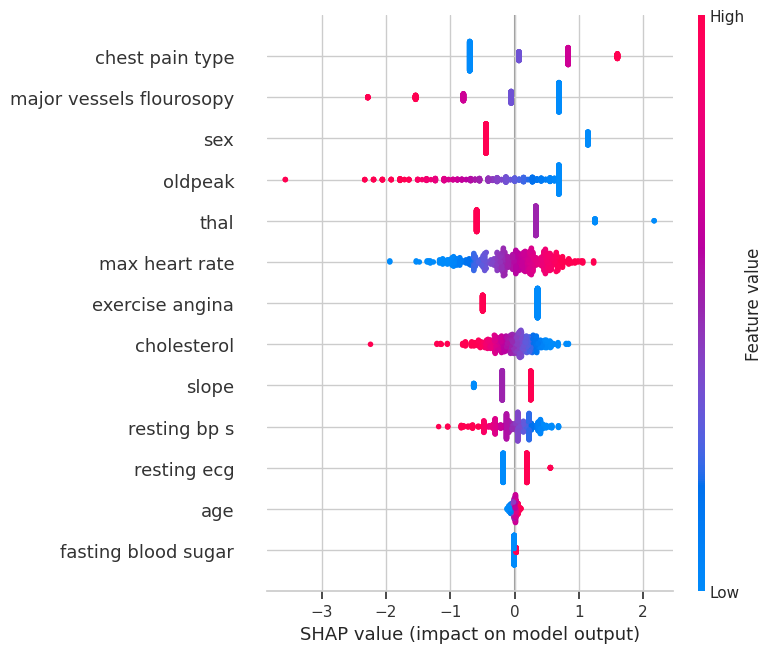

In [ ]:
# Create a SHAP explainer using the training data as the background
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")

# Compute SHAP values for the training set
shap_values = explainer.shap_values(X_train)

# Generate the SHAP summary beeswarm plot
shap.summary_plot(shap_values, X_train, plot_type="dot")

In [ ]:
# Calculate the mean absolute SHAP value for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Mean |SHAP|": mean_abs_shap
})

# Sort the features by importance (descending) and select the top 5
top5_features = feature_importance.sort_values("Mean |SHAP|", ascending=False).head(5)
print("Top 5 Features based on Mean Absolute SHAP Values:")
print(top5_features)

Top 5 Features based on Mean Absolute SHAP Values:
                     Feature  Mean |SHAP|
2            chest pain type     0.715157
11  major vessels flourosopy     0.659581
1                        sex     0.656644
9                    oldpeak     0.637858
12                      thal     0.501730


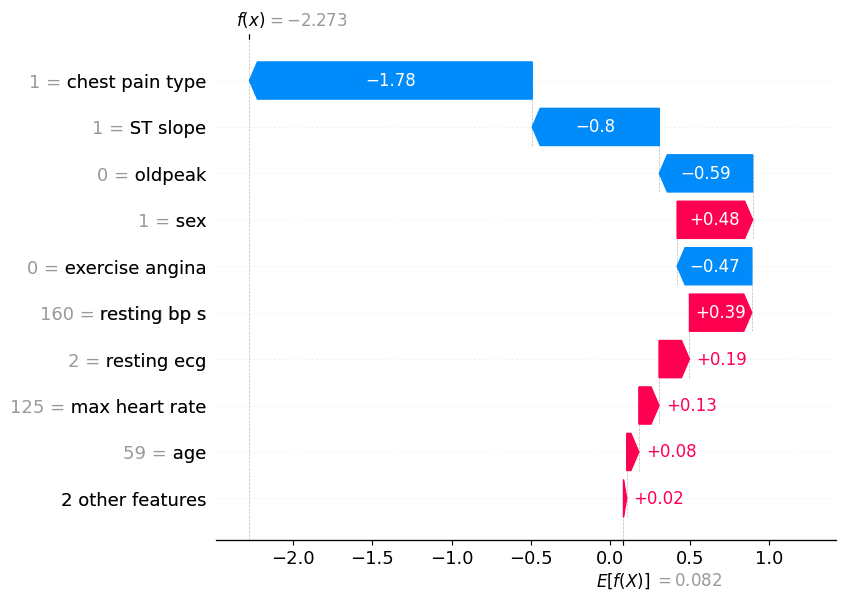

In [ ]:
# Select an individual patient's data from X_test (or define a custom data point)
# Here, we use the first row of X_test as an example
# patient_data = X_test.iloc[0]
patient_data = [59, 1, 1, 160, 273, 0, 2, 125, 0, 0, 1]
patient_data_2d = np.array(patient_data).reshape(1, -1)

# Compute SHAP values for this individual patient
patient_shap_values = explainer.shap_values(patient_data_2d)

# Build a SHAP Explanation object
explanation = shap.Explanation(
    values=patient_shap_values[0],
    base_values=explainer.expected_value,
    data=patient_data_2d[0],
    feature_names=X_train.columns.tolist()  # Ensure this matches your training data feature order
)

# Generate the waterfall plot
shap.waterfall_plot(explanation)

# patient_data_2d = patient_data.values.reshape(1, -1)

# Compute SHAP values for this individual patient
# patient_shap_values = explainer.shap_values(patient_data_2d)

# Create a SHAP Explanation object for the patient data.
# The Explanation object is used by SHAP's visualization functions.
# explanation = shap.Explanation(
#     values=patient_shap_values[0],
#     base_values=explainer.expected_value,
#     data=patient_data.values,
#     feature_names=patient_data.index.tolist()
# )

# # Generate the waterfall plot for the individual patient's prediction
# shap.waterfall_plot(explanation)


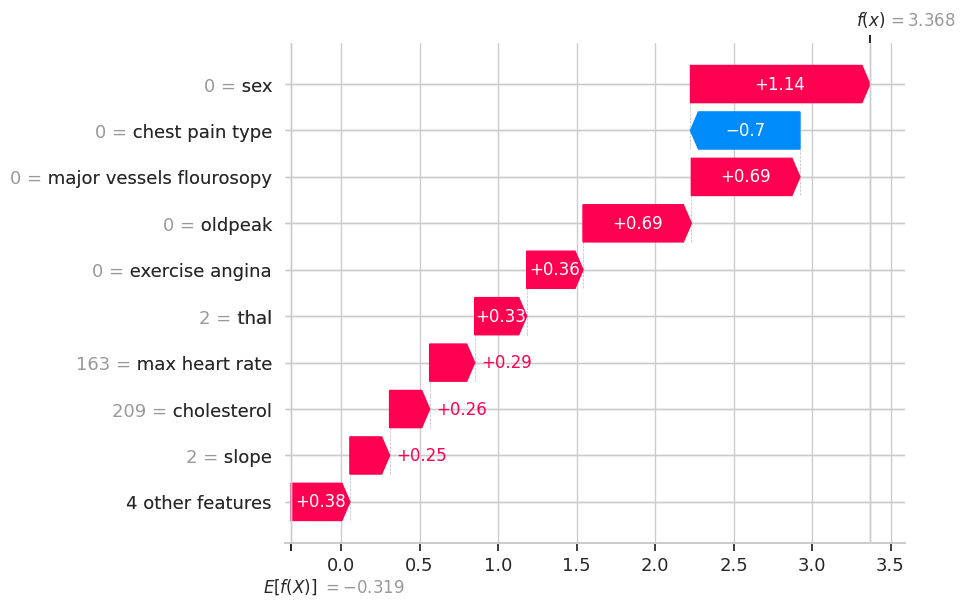

In [ ]:
import numpy as np
import shap

# New patient data (excluding the target value):
# age, sex, chest pain type, resting bp, cholesterol, fasting blood sugar,
# resting ecg, max heart rate, exercise angina, oldpeak, slope, major vessels flourosopy, thal
patient_data = [62, 0, 0, 124, 209, 0, 1, 163, 0, 0.0, 2, 0, 2]
patient_data_2d = np.array(patient_data).reshape(1, -1)

# Compute SHAP values for this individual patient
patient_shap_values = explainer.shap_values(patient_data_2d)

# Build a SHAP Explanation object
explanation = shap.Explanation(
    values=patient_shap_values[0],
    base_values=explainer.expected_value,
    data=patient_data_2d[0],
    feature_names=X_train.columns.tolist()  # Ensure these match your training data feature order
)

# Generate the waterfall plot
shap.waterfall_plot(explanation)


In [ ]:
with open('X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

Preprocessing


In [ ]:
import pandas as pd

# Load the dataset (assuming the CSV file is provided in the Colab environment)
df = pd.read_csv('heart.csv')
# If the target column is named "output" in the CSV, rename it to "target" for consistency
if 'output' in df.columns:
    df = df.rename(columns={'output': 'target'})

# Check original gender distribution
print("Original gender counts:", df['sex'].value_counts().to_dict())

# Separate majority and minority gender classes
df_male = df[df['sex'] == 1]
df_female = df[df['sex'] == 0]
# Randomly undersample the larger class to match the smaller class size
if len(df_male) > len(df_female):
    df_male_under = df_male.sample(n=len(df_female), random_state=42)
    df_balanced = pd.concat([df_male_under, df_female], ignore_index=True)
elif len(df_female) > len(df_male):
    df_female_under = df_female.sample(n=len(df_male), random_state=42)
    df_balanced = pd.concat([df_female_under, df_male], ignore_index=True)
else:
    df_balanced = df.copy()  # already balanced

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
# Verify the new gender distribution
print("Balanced gender counts:", df_balanced['sex'].value_counts().to_dict())


Original gender counts: {1: 713, 0: 312}
Balanced gender counts: {0: 312, 1: 312}


In [ ]:
import numpy as np

# Calculate the absolute correlation matrix for features (exclude the target column from correlation)
feature_cols = [col for col in df_balanced.columns if col != 'target']
corr_matrix = df_balanced[feature_cols].corr().abs()

# Identify upper triangle of the correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation above 0.90
threshold = 0.90
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Drop the highly correlated features
df_reduced = df_balanced.drop(columns=to_drop)
print("Dropped features due to high correlation:", to_drop)
print("Remaining features:", df_reduced.columns.tolist())


Dropped features due to high correlation: []
Remaining features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


In [ ]:
from sklearn.model_selection import train_test_split

# Split 10% of the data for the final hold-out test (Agent test set)
df_model, df_agent_test = train_test_split(df_reduced, test_size=0.10,
                                          stratify=df_reduced['sex'], random_state=42)
# Save the 10% Agent test set to CSV
df_agent_test.to_csv('heart_disease_agent_test.csv', index=False)

# Split the remaining 90% into internal test (~10% of original) and the rest (~80% of original)
df_train_val, df_test = train_test_split(df_model, test_size=0.111111,  # ~10% of original data
                                         stratify=df_model['target'], random_state=42)
# Split the remaining data into train and validation (each ~10% of original for val, ~70% for train)
df_train, df_val = train_test_split(df_train_val, test_size=0.125,     # 0.125 of 80% = 10% of original
                                    stratify=df_train_val['target'], random_state=42)

# Print the sizes of each resulting set
print(f"Train set size: {len(df_train)} records")
print(f"Validation set size: {len(df_val)} records")
print(f"Internal Test set size: {len(df_test)} records")
print(f"Agent Test set size: {len(df_agent_test)} records")


Train set size: 435 records
Validation set size: 63 records
Internal Test set size: 63 records
Agent Test set size: 63 records


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the full preprocessed dataset
df = pd.read_csv("/content/heart_disease_agent_test.csv")  # Example filename
X = df.drop("target", axis=1)
y = df["target"]

# Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)
# Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)


(44, 13) (9, 13) (10, 13)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Define logistic regression and hyperparameter distributions
model = LogisticRegression(solver="liblinear", max_iter=1000, random_state=42)
param_dist = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2"],
    "class_weight": [None, "balanced"]
}
# Randomized search over 20 random combinations, using F1 for evaluation
random_search = RandomizedSearchCV(
    model, param_dist, n_iter=20, scoring="f1", cv=5, random_state=42, refit=True)
random_search.fit(X_train_scaled, y_train)
print("Best hyperparameters:", random_search.best_params_)


Best hyperparameters: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.1}


In [ ]:
best_model = random_search.best_estimator_  # already refitted on X_train_scaled

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate on train, validation, and test
for name, (X_data, y_data) in [("Training", (X_train_scaled, y_train)),
                               ("Validation", (X_val_scaled, y_val)),
                               ("Test", (X_test_scaled, y_test))]:
    y_pred = best_model.predict(X_data)
    y_prob = best_model.predict_proba(X_data)[:,1]
    acc  = accuracy_score(y_data, y_pred)
    prec = precision_score(y_data, y_pred)
    rec  = recall_score(y_data, y_pred)
    f1   = f1_score(y_data, y_pred)
    auc  = roc_auc_score(y_data, y_prob)
    print(f"{name}: Acc={acc:.6f}, Prec={prec:.6f}, Rec={rec:.6f}, F1={f1:.6f}, AUC={auc:.6f}")


Training: Acc=0.909091, Prec=0.846154, Rec=1.000000, F1=0.916667, AUC=0.958678
Validation: Acc=0.888889, Prec=0.800000, Rec=1.000000, F1=0.888889, AUC=0.950000
Test: Acc=0.800000, Prec=0.800000, Rec=0.800000, F1=0.800000, AUC=0.920000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
import joblib
joblib.dump(best_model, "heart_disease_logistic_model.pkl")
print("Model saved to heart_disease_logistic_model.pkl")


Model saved to heart_disease_logistic_model.pkl


In [ ]:
import pickle
# Save X_train to a pickle file
with open('X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Load the full preprocessed dataset
df = pd.read_csv("/content/heart_disease_agent_test.csv")  # Example filename
X = df.drop("target", axis=1)
y = df["target"]

# Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)
# Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

# Initialize and fit the scaler on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test sets using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save the fitted scaler to a pickle file
joblib.dump(scaler, '/content/scaler.pkl')
print("Scaler saved to /content/scaler.pkl")

# --- Continue with model training ---
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Define logistic regression and hyperparameter distributions
model = LogisticRegression(solver="liblinear", max_iter=1000, random_state=42)
param_dist = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2"],
    "class_weight": [None, "balanced"]
}
# Randomized search over 20 random combinations, using F1 for evaluation
random_search = RandomizedSearchCV(
    model, param_dist, n_iter=20, scoring="f1", cv=5, random_state=42, refit=True)
random_search.fit(X_train_scaled, y_train)
print("Best hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_  # already refitted on X_train_scaled

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate on train, validation, and test sets
for name, (X_data, y_data) in [("Training", (X_train_scaled, y_train)),
                               ("Validation", (X_val_scaled, y_val)),
                               ("Test", (X_test_scaled, y_test))]:
    y_pred = best_model.predict(X_data)
    y_prob = best_model.predict_proba(X_data)[:,1]
    acc  = accuracy_score(y_data, y_pred)
    prec = precision_score(y_data, y_pred)
    rec  = recall_score(y_data, y_pred)
    f1   = f1_score(y_data, y_pred)
    auc  = roc_auc_score(y_data, y_prob)
    print(f"{name}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}, AUC={auc:.3f}")


(44, 13) (9, 13) (10, 13)
Scaler saved to /content/scaler.pkl
Best hyperparameters: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.1}
Training: Acc=0.909, Prec=0.846, Rec=1.000, F1=0.917, AUC=0.959
Validation: Acc=0.889, Prec=0.800, Rec=1.000, F1=0.889, AUC=0.950
Test: Acc=0.800, Prec=0.800, Rec=0.800, F1=0.800, AUC=0.920


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


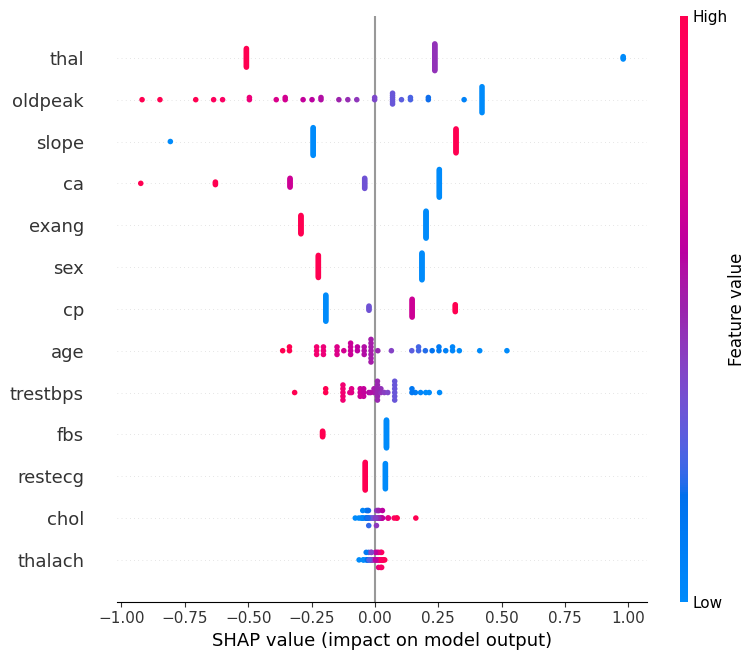

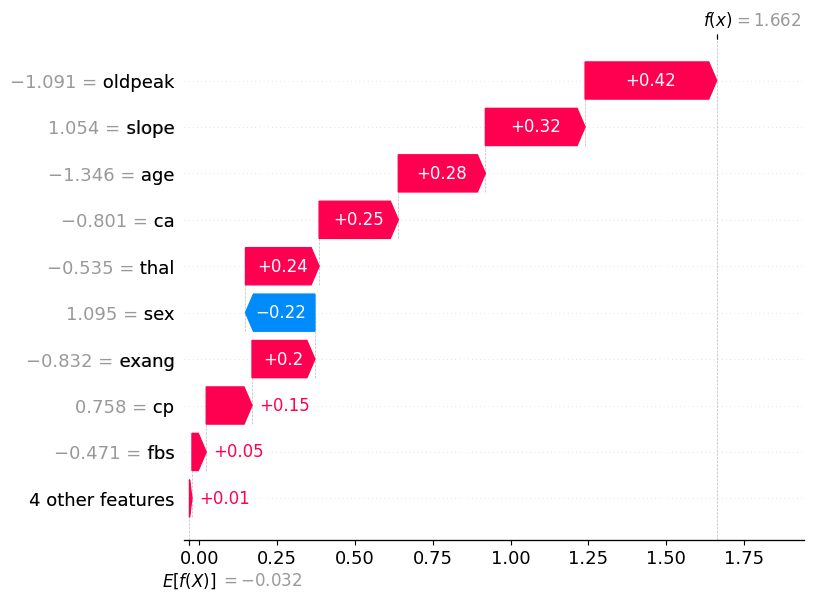

In [ ]:
import joblib
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Load the trained Logistic Regression model
model = joblib.load("heart_disease_logistic_model.pkl")

# Load the scaler that was used during training
scaler = joblib.load("scaler.pkl")

# Load the background dataset from the pickle file using joblib.load
X_train = joblib.load("/content/X_train.pkl")  # This now correctly loads a pickle file

# Scale the background dataset using the loaded scaler
X_train_scaled_array = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns)

# For computational efficiency, sample a subset as the background data.
# Use the minimum of 100 or the number of available samples.
n_background = min(100, len(X_train_scaled))
background = X_train_scaled.sample(n=n_background, random_state=42)

# Initialize the SHAP explainer for our linear model
explainer = shap.LinearExplainer(model, background, feature_perturbation="interventional")

# === Global SHAP: Beeswarm Plot ===
shap_values_global = explainer(X_train_scaled)
shap.summary_plot(shap_values_global, X_train_scaled, plot_type="dot")
plt.show()

# === Local SHAP: Waterfall Plot ===
# Choose an individual instance (the first row)
instance = X_train_scaled.iloc[0:1]  # Single instance as a 2D DataFrame
shap_values_local = explainer(instance)
shap.waterfall_plot(shap_values_local[0])
plt.show()


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


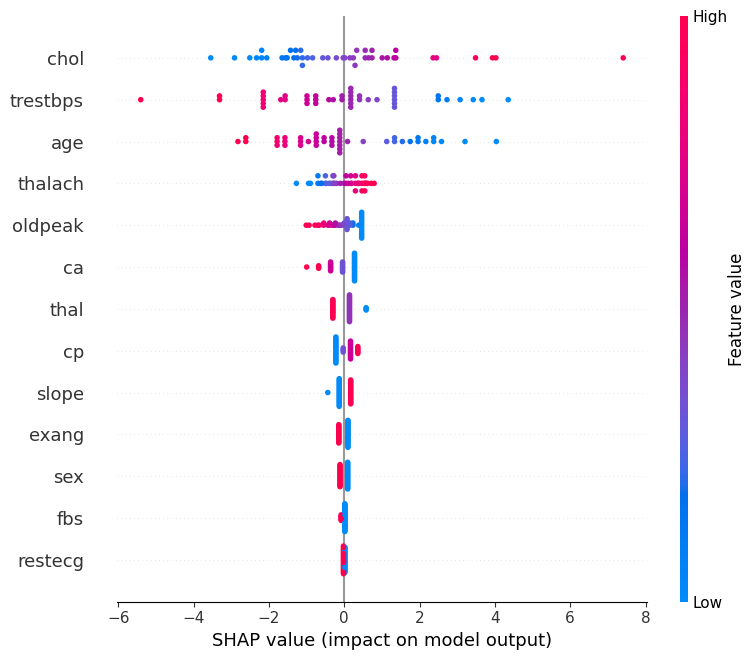

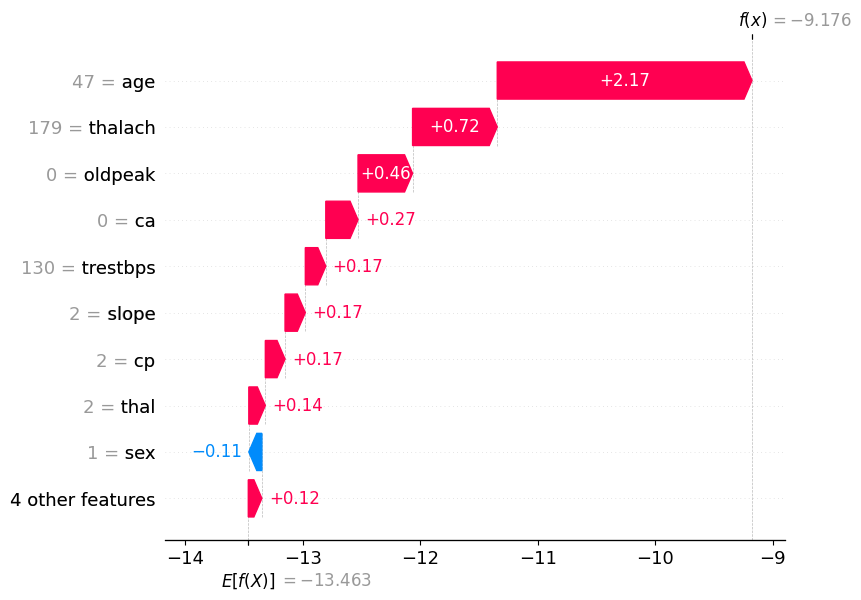

In [ ]:
# import joblib
# import shap
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the trained Logistic Regression model
# model = joblib.load("heart_disease_logistic_model.pkl")

# # Load the background dataset from the pickle file using joblib.load
# X_train = joblib.load("/content/X_train.pkl")  # This now correctly loads a pickle file

# # For computational efficiency, sample a subset as the background data.
# # Use the minimum of 100 or the number of available samples.
# n_background = min(100, len(X_train))
# background = X_train.sample(n=n_background, random_state=42)

# # Initialize the SHAP explainer for our linear model
# explainer = shap.LinearExplainer(model, background, feature_perturbation="interventional")

# # === Global SHAP: Beeswarm Plot ===
# shap_values_global = explainer(X_train)
# shap.summary_plot(shap_values_global, X_train, plot_type="dot")
# plt.show()

# # === Local SHAP: Waterfall Plot ===
# # Choose an individual instance (the first row)
# instance = X_train.iloc[0:2]  # Single instance as a 2D DataFrame
# shap_values_local = explainer(instance)
# shap.waterfall_plot(shap_values_local[0])
# plt.show()


In [ ]:
# Compute the mean absolute SHAP value for each feature
mean_abs_shap = np.abs(shap_values_global.values).mean(axis=0)

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame with feature importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Mean Absolute SHAP": mean_abs_shap
})

# Sort the DataFrame in descending order by mean absolute SHAP value
importance_df = importance_df.sort_values("Mean Absolute SHAP", ascending=False)

# Select the top 5 features
top5_features = importance_df.head(5)

print("Top 5 Feature Importance:")
print(top5_features)

Top 5 Feature Importance:
    Feature  Mean Absolute SHAP
12     thal            0.391704
9   oldpeak            0.321630
10    slope            0.291148
11       ca            0.265949
8     exang            0.238706


In [ ]:
# Save the Agent Test set to a CSV file
df_agent_test.to_csv("agent_test_set.csv", index=False)
print("Agent Test set saved as 'agent_test_set.csv'.")


Agent Test set saved as 'agent_test_set.csv'.
